In [12]:
import pandas as pd
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

2024-08-28 19:40:45.858348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
warnings.filterwarnings('ignore')

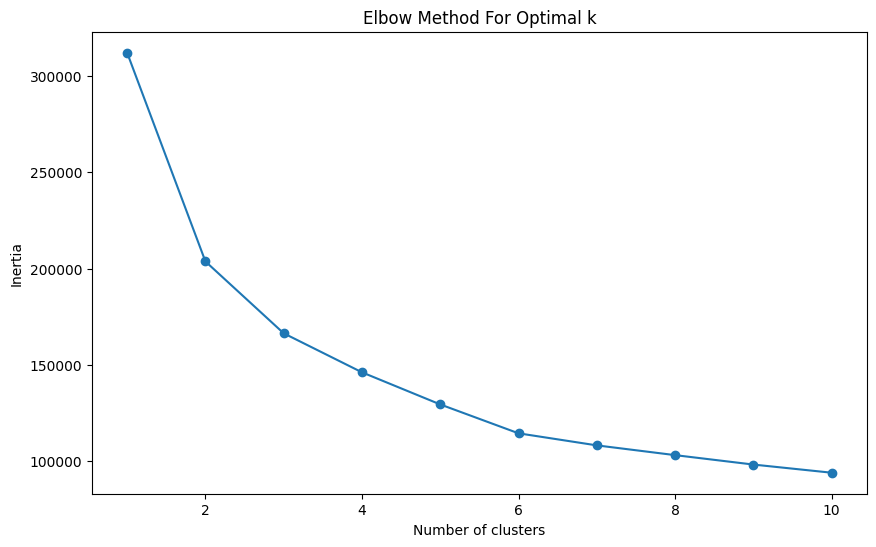

Silhouette Score: 0.245


In [3]:
df = pd.read_excel("preprocessed_data.xlsx")
eval_df = pd.read_excel("evaluation_data_preprocessed.xlsx")


data_for_cluster = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age', 'Personality']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_for_cluster)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal number of clusters (let's assume it's 3 from the plot)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(X_scaled)

clusters = kmeans.predict(X_scaled)

# Add the cluster labels to your original dataframe
data_for_cluster['Cluster'] = clusters
df['Cluster'] = clusters

# Optional: Visualize the clusters if the dimensionality allows
if data_for_cluster.shape[1] <= 5:  # Simplistic check for visualization feasibility
    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='black', s=50, alpha=0.7)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, marker='*', edgecolor='black')
    plt.title('Visualization of clustered data')
    plt.xlabel('Feature 1 (scaled)')
    plt.ylabel('Feature 2 (scaled)')
    plt.show()


# Apply SMOTE
sm = SMOTE(random_state=123)
X, y = df.drop('Preferred_Clothing', axis=1), df['Preferred_Clothing']
X_res, y_res = sm.fit_resample(X, y)

# Combine resampled data back into a DataFrame
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['Preferred_Clothing'] = y_res

df_resampled.drop_duplicates(inplace=True)
df_resampled.fillna(0, inplace=True)
                      
X = df_resampled.drop(columns=["Preferred_Clothing"])
y = df_resampled["Preferred_Clothing"]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

score = silhouette_score(X_scaled, clusters)
print('Silhouette Score: %.3f' % score)

In [4]:
df_preferred_clothing_train = train_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 'Cluster',
                       'resi_lat', 'resi_lon', 'Age', 'Preferred_Clothing', 'Personality']]
df_preferred_clothing_train.drop_duplicates(inplace=True)
df_preferred_clothing_test = test_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 'Cluster',
                       'resi_lat', 'resi_lon', 'Age', 'Preferred_Clothing', 'Personality']]
X_train_1 = df_preferred_clothing_train[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Cluster',
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age', 'Personality']]
X_test_1 = df_preferred_clothing_test[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Cluster',
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age', 'Personality']]

y_train_1 = df_preferred_clothing_train["Preferred_Clothing"]
y_test_1 = df_preferred_clothing_test["Preferred_Clothing"]

# Initialize and train RandomForest
rf_model = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 250 , random_state=42)
rf_model.fit(X_train_1, y_train_1)

# Initialize and train LightGBM
lgb_model = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.8, max_depth=12, n_estimators=200, num_leaves=158, subsample=0.4)
lgb_model.fit(X_train_1, y_train_1)

# Predict probabilities for the test set
rf_probs = rf_model.predict_proba(X_test_1)[:, 1]  # Assuming binary classification
lgb_probs = lgb_model.predict_proba(X_test_1)[:, 1]

# Blend the predictions by averaging
blended_probs = (rf_probs + lgb_probs) / 2

# Convert probabilities to final predictions based on a threshold
final_predictions_test = (blended_probs > 0.50).astype(int)

# Evaluate the blended model
accuracy = accuracy_score(y_test, final_predictions_test)
precision = precision_score(y_test, final_predictions_test, average='binary')  # Adjust average as needed
recall = recall_score(y_test, final_predictions_test, average='binary')        # Adjust average as needed
f1 = f1_score(y_test, final_predictions_test, average='binary') 

print("Blended Model Accuracy: %.4f%%" % (accuracy * 100.0))
print("Precision: %.4f" % (precision * 100.0))
print("Recall: %.4f" % (recall * 100.0))
print("F1 Score: %.4f" % (f1 * 100))

# Calculate confusion matrix
cm = confusion_matrix(y_test_1, final_predictions_test)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

[LightGBM] [Info] Number of positive: 2172, number of negative: 8284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2893
[LightGBM] [Info] Number of data points in the train set: 10456, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207728 -> initscore=-1.338678
[LightGBM] [Info] Start training from score -1.338678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [5]:
#eval_df = pd.read_excel("eval_output.xlsx")
data_for_cluster_eval = eval_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon',
                       'resi_lat', 'resi_lon', 'Age', 'Personality']]

X_eval_scaled = scaler.transform(data_for_cluster_eval)
eval_df['Cluster'] = kmeans.predict(X_eval_scaled)


X_eval = eval_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Cluster',
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age', 'Personality']]
y_eval = eval_df[['Preferred_Clothing']]

# Predict probabilities for the test set
rf_probs = rf_model.predict_proba(X_eval)[:, 1]  # Assuming binary classification
lgb_probs = lgb_model.predict_proba(X_eval)[:, 1]

# Blend the predictions by averaging
blended_probs = (rf_probs + lgb_probs) / 2

# Convert probabilities to final predictions based on a threshold
final_predictions_eval = (blended_probs > 0.50).astype(int)

# Evaluate the blended model
accuracy = accuracy_score(y_eval, final_predictions_eval)
precision = precision_score(y_eval, final_predictions_eval, average='binary')  # Adjust average as needed
recall = recall_score(y_eval, final_predictions_eval, average='binary')        # Adjust average as needed
f1 = f1_score(y_eval, final_predictions_eval, average='binary')                # Adjust average as needed

print("Blended Model Accuracy: %.4f%%" % (accuracy * 100.0))
print("Precision: %.4f" % (precision * 100.0))
print("Recall: %.4f" % (recall * 100.0))
print("F1 Score: %.4f" % (f1 * 100))

# Calculate confusion matrix
cm = confusion_matrix(y_eval, final_predictions_eval)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

Blended Model Accuracy: 86.5424%
Precision: 93.8372
Recall: 91.2896
F1 Score: 92.5459
Confusion Matrix:
[[ 29  53]
 [ 77 807]]
True Positives (TP): 807
False Positives (FP): 53
True Negatives (TN): 29
False Negatives (FN): 77


In [6]:
# Convert y_pred to a DataFrame or Series
y_pred_series = pd.Series(final_predictions_test, name='pred_Preferred_Clothing')

# Ensure the indices match if they are not reset
test_df = test_df.reset_index(drop=True)
y_pred_series = y_pred_series.reset_index(drop=True)

# Combine the predictions with the test DataFrame
df_with_predictions = pd.concat([test_df, y_pred_series], axis=1) 

df_with_piecewear_test = df_with_predictions[df_with_predictions["Preferred_Clothing"] == df_with_predictions["pred_Preferred_Clothing"]]


# Convert y_pred to a DataFrame or Series
y_pred_series = pd.Series(final_predictions_eval, name='pred_Preferred_Clothing')

# Ensure the indices match if they are not reset
eval_df = eval_df.reset_index(drop=True)
y_pred_series = y_pred_series.reset_index(drop=True)

# Combine the predictions with the test DataFrame
eval_df_with_predictions = pd.concat([eval_df, y_pred_series], axis=1) 

df_with_piecewear_eval = eval_df_with_predictions[eval_df_with_predictions["Preferred_Clothing"] == eval_df_with_predictions["pred_Preferred_Clothing"]]



In [7]:
#2 piece wear
df_twopiece_test = df_with_piecewear_test[df_with_piecewear_test["Preferred_Clothing"] == 1]

X_twopiece_test = df_twopiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_twopiece_test = df_twopiece_test[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]

df_twopiece_train = train_df[train_df["Preferred_Clothing"] == 1]
df_twopiece_train = df_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 
            'Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
df_twopiece_train.drop_duplicates(inplace=True)
X_twopiece_train = df_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_twopiece_train = df_twopiece_train[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='entropy', random_state=42)
#criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_twopiece_train, y_twopiece_train)

# Predicting the test set results
y_pred_test = multi_rf_classifier.predict(X_twopiece_test)

# Lists to store metrics for each label
accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1_scores = []
micro_precisions = []
micro_recalls = []
micro_f1_scores = []

# Iterate over each target column
for i in range(y_twopiece_test.shape[1]):
    accuracies.append(accuracy_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i]))
    macro_precisions.append(precision_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
    macro_recalls.append(recall_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
    macro_f1_scores.append(f1_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
    micro_precisions.append(precision_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
    micro_recalls.append(recall_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
    micro_f1_scores.append(f1_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
    
# Output the calculated metrics for each target
for i, column in enumerate(y_twopiece_test.columns):
    print(f"Metrics for {column}:")
    print(f"  Accuracy: {accuracies[i]:.2f}")
    print(f"  Macro Precision: {macro_precisions[i]:.2f}")
    print(f"  Macro Recall: {macro_recalls[i]:.2f}")
    print(f"  Macro F1 Score: {macro_f1_scores[i]:.2f}")
    print(f"  Micro Precision: {micro_precisions[i]:.2f}")
    print(f"  Micro Recall: {micro_recalls[i]:.2f}")
    print(f"  Micro F1 Score: {micro_f1_scores[i]:.2f}")
    print("\n" + "-"*80 + "\n")

# Calculate overall metrics by averaging
overall_accuracy = sum(accuracies) / len(accuracies)
overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

print(f"\nOverall Metrics:")
print(f"  Overall Accuracy: {overall_accuracy:.2f}")
print(f"  Overall Macro Precision: {overall_macro_precision:.2f}")
print(f"  Overall Macro Recall: {overall_macro_recall:.2f}")
print(f"  Overall Macro F1 Score: {overall_macro_f1:.2f}")
print(f"  Overall Micro Precision: {overall_micro_precision:.2f}")
print(f"  Overall Micro Recall: {overall_micro_recall:.2f}")
print(f"  Overall Micro F1 Score: {overall_micro_f1:.2f}")


Metrics for Preferred_Bottoms:
  Accuracy: 0.89
  Macro Precision: 0.91
  Macro Recall: 0.90
  Macro F1 Score: 0.91
  Micro Precision: 0.89
  Micro Recall: 0.89
  Micro F1 Score: 0.89

--------------------------------------------------------------------------------

Metrics for Bottoms_Material:
  Accuracy: 0.96
  Macro Precision: 0.95
  Macro Recall: 0.94
  Macro F1 Score: 0.95
  Micro Precision: 0.96
  Micro Recall: 0.96
  Micro F1 Score: 0.96

--------------------------------------------------------------------------------

Metrics for Bottoms_Length:
  Accuracy: 0.99
  Macro Precision: 0.73
  Macro Recall: 0.70
  Macro F1 Score: 0.71
  Micro Precision: 0.99
  Micro Recall: 0.99
  Micro F1 Score: 0.99

--------------------------------------------------------------------------------

Metrics for Bottoms_Fitting:
  Accuracy: 0.99
  Macro Precision: 0.86
  Macro Recall: 0.87
  Macro F1 Score: 0.83
  Micro Precision: 0.99
  Micro Recall: 0.99
  Micro F1 Score: 0.99

--------------------

In [8]:
column_name = ["pred_"+col for col in y_twopiece_test.columns]
y_pred_df = pd.DataFrame(y_pred_test, columns=column_name, index=y_twopiece_test.index)
df_with_predictions = pd.merge(df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')

In [9]:
#2 piece wear
df_twopiece_eval = df_with_piecewear_eval[df_with_piecewear_eval["Preferred_Clothing"] == 1]

X_twopiece_eval = df_twopiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_twopiece_eval = df_twopiece_eval[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]

# Predicting the test set results
y_pred_eval = multi_rf_classifier.predict(X_twopiece_eval)

# Initialize lists to store the metrics for each target
accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1_scores = []
micro_precisions = []
micro_recalls = []
micro_f1_scores = []

# Iterate over each target column
for i in range(y_twopiece_eval.shape[1]):
    accuracies.append(accuracy_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i]))
    macro_precisions.append(precision_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    macro_recalls.append(recall_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    macro_f1_scores.append(f1_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    micro_precisions.append(precision_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    micro_recalls.append(recall_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    micro_f1_scores.append(f1_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))

# Output the calculated metrics for each target
for i, column in enumerate(y_twopiece_train.columns):
    print(f"Metrics for {column}:")
    print(f"  Accuracy: {accuracies[i]:.2f}")
    print(f"  Macro Precision: {macro_precisions[i]:.2f}")
    print(f"  Macro Recall: {macro_recalls[i]:.2f}")
    print(f"  Macro F1 Score: {macro_f1_scores[i]:.2f}")
    print(f"  Micro Precision: {micro_precisions[i]:.2f}")
    print(f"  Micro Recall: {micro_recalls[i]:.2f}")
    print(f"  Micro F1 Score: {micro_f1_scores[i]:.2f}")
    print("\n" + "-"*80 + "\n")

# Calculate overall metrics by averaging
average_accuracy = sum(accuracies) / len(accuracies)
average_macro_precision = sum(macro_precisions) / len(macro_precisions)
average_macro_recall = sum(macro_recalls) / len(macro_recalls)
average_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
average_micro_precision = sum(micro_precisions) / len(micro_precisions)
average_micro_recall = sum(micro_recalls) / len(micro_recalls)
average_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

print(f"\nOverall Metrics:")
print(f"  Average Accuracy: {average_accuracy:.2f}")
print(f"  Average Macro Precision: {average_macro_precision:.2f}")
print(f"  Average Macro Recall: {average_macro_recall:.2f}")
print(f"  Average Macro F1 Score: {average_macro_f1:.2f}")
print(f"  Average Micro Precision: {average_micro_precision:.2f}")
print(f"  Average Micro Recall: {average_micro_recall:.2f}")
print(f"  Average Micro F1 Score: {average_micro_f1:.2f}")


Metrics for Preferred_Bottoms:
  Accuracy: 0.44
  Macro Precision: 0.15
  Macro Recall: 0.14
  Macro F1 Score: 0.12
  Micro Precision: 0.44
  Micro Recall: 0.44
  Micro F1 Score: 0.44

--------------------------------------------------------------------------------

Metrics for Bottoms_Material:
  Accuracy: 0.49
  Macro Precision: 0.14
  Macro Recall: 0.16
  Macro F1 Score: 0.15
  Micro Precision: 0.49
  Micro Recall: 0.49
  Micro F1 Score: 0.49

--------------------------------------------------------------------------------

Metrics for Bottoms_Length:
  Accuracy: 0.74
  Macro Precision: 0.15
  Macro Recall: 0.20
  Macro F1 Score: 0.17
  Micro Precision: 0.74
  Micro Recall: 0.74
  Micro F1 Score: 0.74

--------------------------------------------------------------------------------

Metrics for Bottoms_Fitting:
  Accuracy: 0.42
  Macro Precision: 0.47
  Macro Recall: 0.24
  Macro F1 Score: 0.25
  Micro Precision: 0.42
  Micro Recall: 0.42
  Micro F1 Score: 0.42

--------------------

In [10]:
column_name = ["pred_"+col for col in y_twopiece_eval.columns]
y_pred_df = pd.DataFrame(y_pred_eval, columns=column_name, index=y_twopiece_eval.index)
eval_df_with_predictions = pd.merge(eval_df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')

In [92]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from joblib import dump, load

# Data preparation (assuming the code to prepare df_color_twopiece_train and df_twopiece_test is the same as before)
X_color_twopiece_test = df_twopiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
           'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
           'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_twopiece_test = df_twopiece_test[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]

df_color_twopiece_train = train_df[train_df["Preferred_Clothing"] == 1]
df_color_twopiece_train = df_color_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
           'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
           'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 
            'Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
df_color_twopiece_train.drop_duplicates(inplace=True)
X_color_twopiece_train = df_color_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
           'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
           'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_twopiece_train = df_color_twopiece_train[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]

# Normalize features and targets with StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_color_twopiece_train)
y_scaled = scaler_y.fit_transform(y_color_twopiece_train)
X_test_scaled = scaler_X.transform(X_color_twopiece_test)
y_test_scaled = scaler_y.transform(y_color_twopiece_test)

dump(scaler_X, 'scaler_X_twop_standard.joblib')
dump(scaler_y, 'scaler_y_twop_standard.joblib')

# Reshape input to be [samples, features, 1] for 1D CNN
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Build 1D CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=5),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(y_scaled.shape[1])
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_scaled, y_scaled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss: {test_loss}')
y_pred = model.predict(X_test_scaled) 

# Save the model
model.save('cnn_model_twopiece_standard.h5')


Epoch 1/100


2024-08-28 21:30:42.610186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-28 21:30:42.658605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


248/248 [==============================] - ETA: 0s - loss: 0.9805 - mean_squared_error: 0.9805

2024-08-28 21:30:46.255383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 5s 16ms/step - loss: 0.9805 - mean_squared_error: 0.9805 - val_loss: 1.4017 - val_mean_squared_error: 1.4017
Epoch 2/100
248/248 [==============================] - 4s 15ms/step - loss: 0.9577 - mean_squared_error: 0.9577 - val_loss: 1.3300 - val_mean_squared_error: 1.3300
Epoch 3/100
248/248 [==============================] - 3s 14ms/step - loss: 0.9428 - mean_squared_error: 0.9428 - val_loss: 1.3262 - val_mean_squared_error: 1.3262
Epoch 4/100
248/248 [==============================] - 4s 15ms/step - loss: 0.9446 - mean_squared_error: 0.9446 - val_loss: 1.2903 - val_mean_squared_error: 1.2903
Epoch 5/100
248/248 [==============================] - 3s 13ms/step - loss: 0.9350 - mean_squared_error: 0.9350 - val_loss: 1.3479 - val_mean_squared_error: 1.3479
Epoch 6/100
248/248 [==============================] - 3s 14ms/step - loss: 0.9378 - mean_squared_error: 0.9378 - val_loss: 1.2396 - val_mean_squared_error: 1.2396
Epoch 7/100
248/248 [=======

2024-08-28 21:31:43.098059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 0s 3ms/step


In [93]:
X_color_twopiece_eval = df_twopiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
           'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
           'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_twopiece_eval = df_twopiece_eval[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]

X_eval_scaled = scaler_X.transform(X_color_twopiece_eval)
y_eval_scaled = scaler_y.transform(y_color_twopiece_eval)

X_eval_scaled = X_eval_scaled.reshape((X_eval_scaled.shape[0], X_eval_scaled.shape[1], 1))

# Evaluate the model
test_loss = model.evaluate(X_eval_scaled, y_eval_scaled)
print(f'Test Loss: {test_loss}')
y_pred = model.predict(X_eval_scaled) 

26/26 [==============================] - 0s 8ms/step - loss: 1.1024 - mean_squared_error: 1.1024
Test Loss: [1.102442741394043, 1.102442741394043]
26/26 [==============================] - 0s 4ms/step


In [80]:
#2 piece wear
df_onepiece_test = df_with_piecewear_test[df_with_piecewear_test["Preferred_Clothing"] == 0]

X_onepiece_test = df_onepiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_onepiece_test = df_onepiece_test[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
          'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]

df_onepiece_train = train_df[train_df["Preferred_Clothing"] == 0]
df_onepiece_train = df_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
        'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
        'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 'Single_Piece_Material', 
        'Single_Piece_Fitting', 'Single_Piece_Length','Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
df_onepiece_train.drop_duplicates(inplace=True)
X_onepiece_train = df_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_onepiece_train = df_onepiece_train[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
          'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split= 2, n_estimators=200, random_state=42)

# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_onepiece_train, y_onepiece_train)

# Predicting the test set results
y_pred_test = multi_rf_classifier.predict(X_onepiece_test)


# Initialize lists to store the metrics for each target
accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1_scores = []
micro_precisions = []
micro_recalls = []
micro_f1_scores = []

# Iterate over each target column
for i in range(y_onepiece_test.shape[1]):
    accuracies.append(accuracy_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i]))
    macro_precisions.append(precision_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
    macro_recalls.append(recall_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
    macro_f1_scores.append(f1_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
    micro_precisions.append(precision_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
    micro_recalls.append(recall_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
    micro_f1_scores.append(f1_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))

# Output the calculated metrics for each target
for i, column in enumerate(y_onepiece_train.columns):
    print(f"Metrics for {column}:")
    print(f"  Accuracy: {accuracies[i]:.2f}")
    print(f"  Macro Precision: {macro_precisions[i]:.2f}")
    print(f"  Macro Recall: {macro_recalls[i]:.2f}")
    print(f"  Macro F1 Score: {macro_f1_scores[i]:.2f}")
    print(f"  Micro Precision: {micro_precisions[i]:.2f}")
    print(f"  Micro Recall: {micro_recalls[i]:.2f}")
    print(f"  Micro F1 Score: {micro_f1_scores[i]:.2f}")
    print("\n" + "-"*80 + "\n")

# Calculate overall metrics by averaging
overall_accuracy = sum(accuracies) / len(accuracies)
overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

print(f"\nOverall Metrics:")
print(f"  Overall Accuracy: {overall_accuracy:.2f}")
print(f"  Overall Macro Precision: {overall_macro_precision:.2f}")
print(f"  Overall Macro Recall: {overall_macro_recall:.2f}")
print(f"  Overall Macro F1 Score: {overall_macro_f1:.2f}")
print(f"  Overall Micro Precision: {overall_micro_precision:.2f}")
print(f"  Overall Micro Recall: {overall_micro_recall:.2f}")
print(f"  Overall Micro F1 Score: {overall_micro_f1:.2f}")

Metrics for Favourite_Single_Piece:
  Accuracy: 0.88
  Macro Precision: 0.59
  Macro Recall: 0.55
  Macro F1 Score: 0.53
  Micro Precision: 0.88
  Micro Recall: 0.88
  Micro F1 Score: 0.88

--------------------------------------------------------------------------------

Metrics for Single_Piece_Material:
  Accuracy: 0.93
  Macro Precision: 0.80
  Macro Recall: 0.81
  Macro F1 Score: 0.79
  Micro Precision: 0.93
  Micro Recall: 0.93
  Micro F1 Score: 0.93

--------------------------------------------------------------------------------

Metrics for Single_Piece_Fitting:
  Accuracy: 0.94
  Macro Precision: 0.92
  Macro Recall: 0.89
  Macro F1 Score: 0.90
  Micro Precision: 0.94
  Micro Recall: 0.94
  Micro F1 Score: 0.94

--------------------------------------------------------------------------------

Metrics for Single_Piece_Length:
  Accuracy: 0.90
  Macro Precision: 0.73
  Macro Recall: 0.72
  Macro F1 Score: 0.72
  Micro Precision: 0.90
  Micro Recall: 0.90
  Micro F1 Score: 0.90



In [14]:
column_name = ["pred_"+col for col in y_onepiece_test.columns]
y_pred_df = pd.DataFrame(y_pred_test, columns=column_name, index=y_onepiece_test.index)
df_with_predictions = pd.merge(df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')

In [86]:
#2 piece wear
df_onepiece_eval = df_with_piecewear_eval[df_with_piecewear_eval["Preferred_Clothing"] == 0]

X_onepiece_eval = df_onepiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_onepiece_eval = df_onepiece_eval[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
          'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]



# Predicting the test set results
y_pred_eval = multi_rf_classifier.predict(X_onepiece_eval)

# Initialize lists to store the metrics for each target
accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1_scores = []
micro_precisions = []
micro_recalls = []
micro_f1_scores = []

# Iterate over each target column
for i in range(y_onepiece_eval.shape[1]):
    accuracies.append(accuracy_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i]))
    macro_precisions.append(precision_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    macro_recalls.append(recall_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    macro_f1_scores.append(f1_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    micro_precisions.append(precision_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    micro_recalls.append(recall_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    micro_f1_scores.append(f1_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))

# Output the calculated metrics for each target
for i, column in enumerate(y_onepiece_eval.columns):
    print(f"Metrics for {column}:")
    print(f"  Accuracy: {accuracies[i]:.2f}")
    print(f"  Macro Precision: {macro_precisions[i]:.2f}")
    print(f"  Macro Recall: {macro_recalls[i]:.2f}")
    print(f"  Macro F1 Score: {macro_f1_scores[i]:.2f}")
    print(f"  Micro Precision: {micro_precisions[i]:.2f}")
    print(f"  Micro Recall: {micro_recalls[i]:.2f}")
    print(f"  Micro F1 Score: {micro_f1_scores[i]:.2f}")
    print("\n" + "-"*80 + "\n")

# Calculate overall metrics by averaging
overall_accuracy = sum(accuracies) / len(accuracies)
overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

print(f"\nOverall Metrics:")
print(f"  Overall Accuracy: {overall_accuracy:.2f}")
print(f"  Overall Macro Precision: {overall_macro_precision:.2f}")
print(f"  Overall Macro Recall: {overall_macro_recall:.2f}")
print(f"  Overall Macro F1 Score: {overall_macro_f1:.2f}")
print(f"  Overall Micro Precision: {overall_micro_precision:.2f}")
print(f"  Overall Micro Recall: {overall_micro_recall:.2f}")
print(f"  Overall Micro F1 Score: {overall_micro_f1:.2f}")

Metrics for Favourite_Single_Piece:
  Accuracy: 0.86
  Macro Precision: 0.40
  Macro Recall: 0.38
  Macro F1 Score: 0.39
  Micro Precision: 0.86
  Micro Recall: 0.86
  Micro F1 Score: 0.86

--------------------------------------------------------------------------------

Metrics for Single_Piece_Material:
  Accuracy: 0.69
  Macro Precision: 0.50
  Macro Recall: 0.34
  Macro F1 Score: 0.41
  Micro Precision: 0.69
  Micro Recall: 0.69
  Micro F1 Score: 0.69

--------------------------------------------------------------------------------

Metrics for Single_Piece_Fitting:
  Accuracy: 0.69
  Macro Precision: 0.46
  Macro Recall: 0.31
  Macro F1 Score: 0.32
  Micro Precision: 0.69
  Micro Recall: 0.69
  Micro F1 Score: 0.69

--------------------------------------------------------------------------------

Metrics for Single_Piece_Length:
  Accuracy: 0.41
  Macro Precision: 0.37
  Macro Recall: 0.34
  Macro F1 Score: 0.29
  Micro Precision: 0.41
  Micro Recall: 0.41
  Micro F1 Score: 0.41



In [16]:
column_name = ["pred_"+col for col in y_onepiece_eval.columns]
y_pred_df = pd.DataFrame(y_pred_eval, columns=column_name, index=y_onepiece_eval.index)
eval_df_with_predictions = pd.merge(eval_df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')

In [17]:
#1 piece wear
X_color_onepiece_test = df_onepiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_onepiece_test = df_onepiece_test[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]

df_color_onepiece_train = train_df[train_df["Preferred_Clothing"] == 0]
df_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 
        'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]
df_color_onepiece_train.drop_duplicates(inplace=True)
X_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_onepiece_train = df_color_onepiece_train[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 
                                                  'Single_Piece_Color_b']]

# Normalize features and targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_color_onepiece_train)
y_scaled = scaler_y.fit_transform(y_color_onepiece_train)
X_test_scaled = scaler_X.transform(X_color_onepiece_test)
y_test_scaled = scaler_y.transform(y_color_onepiece_test)

# Reshape input to be [samples, time steps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_scaled.shape[2])),
    Dense(y_scaled.shape[1])
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_scaled, y_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss: {test_loss}')

model.save('lstm_model_1.h5')


NameError: name 'Sequential' is not defined

In [94]:
X_color_onepiece_test = df_onepiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_onepiece_test = df_onepiece_test[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]

df_color_onepiece_train = train_df[train_df["Preferred_Clothing"] == 0]
df_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 
        'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]
df_color_onepiece_train.drop_duplicates(inplace=True)
X_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_onepiece_train = df_color_onepiece_train[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 
                                                  'Single_Piece_Color_b']]

# Normalize features and targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_color_onepiece_train)
y_scaled = scaler_y.fit_transform(y_color_onepiece_train)
X_test_scaled = scaler_X.transform(X_color_onepiece_test)
y_test_scaled = scaler_y.transform(y_color_onepiece_test)

# Reshape input to be [samples, features, 1] for 1D CNN
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Build 1D CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=5),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(y_scaled.shape[1])
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_scaled, y_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss: {test_loss}')

# Save the model
model.save('cnn_model_onepiece.h5')


Epoch 1/50


2024-08-28 21:35:04.855981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-28 21:35:04.900375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


267/267 [==============================] - ETA: 0s - loss: 0.0226 - mean_squared_error: 0.0226

2024-08-28 21:35:08.693015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


267/267 [==============================] - 5s 15ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 2/50
267/267 [==============================] - 3s 13ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 3/50
267/267 [==============================] - 4s 14ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 4/50
267/267 [==============================] - 3s 13ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 5/50
267/267 [==============================] - 4s 13ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 6/50
267/267 [==============================] - 4s 13ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 7/50
267/267 [=============

In [95]:
X_color_onepiece_eval = df_onepiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_onepiece_eval = df_onepiece_eval[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 
                                                  'Single_Piece_Color_b']]

X_eval_scaled = scaler_X.transform(X_color_onepiece_eval)
y_eval_scaled = scaler_y.transform(y_color_onepiece_eval)

X_eval_scaled = X_eval_scaled.reshape((X_eval_scaled.shape[0], X_eval_scaled.shape[1], 1))

test_loss = model.evaluate(X_eval_scaled, y_eval_scaled)

print(f'Test Loss: {test_loss}')


1/1 [==============================] - 0s 76ms/step - loss: 0.0383 - mean_squared_error: 0.0383
Test Loss: [0.038306523114442825, 0.038306523114442825]


In [19]:
df_with_predictions.fillna(0, inplace=True)

columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
 'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
 'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']


# Initialize lists to store metrics for each column
metrics_data = {
    "Column": [],
    "Accuracy": [],
    "Macro Precision": [],
    "Macro Recall": [],
    "Macro F1 Score": [],
    "Micro Precision": [],
    "Micro Recall": [],
    "Micro F1 Score": []
}

# Calculate metrics for each column
for col in columns_accuracy:
    accuracy = accuracy_score(df_with_predictions[col], df_with_predictions["pred_" + col])
    macro_precision = precision_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
    macro_recall = recall_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
    macro_f1 = f1_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
    micro_precision = precision_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
    micro_recall = recall_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
    micro_f1 = f1_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
    
    # Append the metrics to the data dictionary
    metrics_data["Column"].append(col)
    metrics_data["Accuracy"].append(accuracy)
    metrics_data["Macro Precision"].append(macro_precision)
    metrics_data["Macro Recall"].append(macro_recall)
    metrics_data["Macro F1 Score"].append(macro_f1)
    metrics_data["Micro Precision"].append(micro_precision)
    metrics_data["Micro Recall"].append(micro_recall)
    metrics_data["Micro F1 Score"].append(micro_f1)

# Calculate overall metrics by averaging
overall_metrics = {
    "Column": ["Overall"],
    "Accuracy": [sum(metrics_data["Accuracy"]) / len(metrics_data["Accuracy"])],
    "Macro Precision": [sum(metrics_data["Macro Precision"]) / len(metrics_data["Macro Precision"])],
    "Macro Recall": [sum(metrics_data["Macro Recall"]) / len(metrics_data["Macro Recall"])],
    "Macro F1 Score": [sum(metrics_data["Macro F1 Score"]) / len(metrics_data["Macro F1 Score"])],
    "Micro Precision": [sum(metrics_data["Micro Precision"]) / len(metrics_data["Micro Precision"])],
    "Micro Recall": [sum(metrics_data["Micro Recall"]) / len(metrics_data["Micro Recall"])],
    "Micro F1 Score": [sum(metrics_data["Micro F1 Score"]) / len(metrics_data["Micro F1 Score"])]
}

# Convert the metrics data to a DataFrame
df_metrics = pd.DataFrame(metrics_data)
df_overall_metrics = pd.DataFrame(overall_metrics)

# Append overall metrics to the DataFrame
df_metrics = df_metrics.append(df_overall_metrics, ignore_index=True)

# Save the metrics to an Excel file
df_metrics.to_excel("model_test_metrics_with_personality.xlsx", index=False)

print("Metrics saved to 'model_test_metrics.xlsx'")
df_metrics


Metrics saved to 'model_test_metrics.xlsx'


Column  Accuracy  Macro Precision  Macro Recall  \
0       Preferred_Clothing  0.995678         0.996033      0.995009   
1   Favourite_Single_Piece  0.946586         0.591031      0.549960   
2    Single_Piece_Material  0.967156         0.802509      0.805504   
3     Single_Piece_Fitting  0.972515         0.927223      0.904394   
4      Single_Piece_Length  0.956958         0.732755      0.725761   
5     Single_Piece_Sleeves  0.950908         0.795212      0.791863   
6    Single_Piece_Neckline  0.964736         0.839759      0.839701   
7     Single_Piece_Pattern  0.803284         0.357363      0.337443   
8        Preferred_Bottoms  0.933449         0.913097      0.903730   
9         Bottoms_Material  0.973034         0.954618      0.941927   
10          Bottoms_Length  0.990666         0.758199      0.722704   
11         Bottoms_Fitting  0.992394         0.871176      0.875867   
12     Preferred_Upperwear  0.966984         0.811163      0.833556   
13      Upperwear_Material  0.970787         0.635743      0.722715   
14        Upperwear_Length  0.968021         0.814672      0.887319   
15      Upperwear_Neckline  0.994296         0.997891      0.993766   
16   Upperwear_Sleeve_Type  0.984443         0.830411      0.859663   
17       Upperwear_Pattern  0.738807         0.211543      0.303999   
18                 Overall  0.948372         0.768911      0.777493   

    Macro F1 Score  Micro Precision  Micro Recall  Micro F1 Score  
0         0.995513         0.995678      0.995678        0.995678  
1         0.532110         0.946586      0.946586        0.946586  
2         0.788528         0.967156      0.967156        0.967156  
3         0.914937         0.972515      0.972515        0.972515  
4         0.722699         0.956958      0.956958        0.956958  
5         0.791265         0.950908      0.950908        0.950908  
6         0.832560         0.964736      0.964736        0.964736  
7         0.319473         0.803284      0.803284        0.803284  
8         0.908206         0.933449      0.933449        0.933449  
9         0.946281         0.973034      0.973034        0.973034  
10        0.738532         0.990666      0.990666        0.990666  
11        0.836585         0.992394      0.992394        0.992394  
12        0.791392         0.966984      0.966984        0.966984  
13        0.661819         0.970787      0.970787        0.970787  
14        0.830054         0.968021      0.968021        0.968021  
15        0.995786         0.994296      0.994296        0.994296  
16        0.839502         0.984443      0.984443        0.984443  
17        0.232559         0.738807      0.738807        0.738807  
18        0.759878         0.948372      0.948372        0.948372

In [20]:
eval_df_with_predictions.fillna(0, inplace=True)

columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
 'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
 'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']

# Initialize lists to store metrics for each column
metrics_data = {
    "Column": [],
    "Accuracy": [],
    "Macro Precision": [],
    "Macro Recall": [],
    "Macro F1 Score": [],
    "Micro Precision": [],
    "Micro Recall": [],
    "Micro F1 Score": []
}

# Calculate metrics for each column
for col in columns_accuracy:
    accuracy = accuracy_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col])
    macro_precision = precision_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
    macro_recall = recall_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
    macro_f1 = f1_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
    micro_precision = precision_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
    micro_recall = recall_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
    micro_f1 = f1_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
    
    # Append the metrics to the data dictionary
    metrics_data["Column"].append(col)
    metrics_data["Accuracy"].append(accuracy)
    metrics_data["Macro Precision"].append(macro_precision)
    metrics_data["Macro Recall"].append(macro_recall)
    metrics_data["Macro F1 Score"].append(macro_f1)
    metrics_data["Micro Precision"].append(micro_precision)
    metrics_data["Micro Recall"].append(micro_recall)
    metrics_data["Micro F1 Score"].append(micro_f1)

# Calculate overall metrics by averaging
overall_metrics = {
    "Column": ["Overall"],
    "Accuracy": [sum(metrics_data["Accuracy"]) / len(metrics_data["Accuracy"])],
    "Macro Precision": [sum(metrics_data["Macro Precision"]) / len(metrics_data["Macro Precision"])],
    "Macro Recall": [sum(metrics_data["Macro Recall"]) / len(metrics_data["Macro Recall"])],
    "Macro F1 Score": [sum(metrics_data["Macro F1 Score"]) / len(metrics_data["Macro F1 Score"])],
    "Micro Precision": [sum(metrics_data["Micro Precision"]) / len(metrics_data["Micro Precision"])],
    "Micro Recall": [sum(metrics_data["Micro Recall"]) / len(metrics_data["Micro Recall"])],
    "Micro F1 Score": [sum(metrics_data["Micro F1 Score"]) / len(metrics_data["Micro F1 Score"])]
}

# Convert the metrics data to a DataFrame
df_metrics = pd.DataFrame(metrics_data)
df_overall_metrics = pd.DataFrame(overall_metrics)

# Append overall metrics to the DataFrame
df_metrics = df_metrics.append(df_overall_metrics, ignore_index=True)

# Save the metrics to an Excel file
df_metrics.to_excel("model_eval_metrics_with_personality.xlsx", index=False)

print("Metrics saved to 'model_eval_metrics.xlsx'")
df_metrics


Metrics saved to 'model_eval_metrics.xlsx'


Column  Accuracy  Macro Precision  Macro Recall  \
0       Preferred_Clothing  0.865424         0.605978      0.633277   
1   Favourite_Single_Piece  0.940994         0.490573      0.268229   
2    Single_Piece_Material  0.935818         0.485859      0.318493   
3     Single_Piece_Fitting  0.935818         0.560116      0.297981   
4      Single_Piece_Length  0.927536         0.467845      0.270962   
5     Single_Piece_Sleeves  0.933747         0.271877      0.203846   
6    Single_Piece_Neckline  0.942029         0.403348      0.247762   
7     Single_Piece_Pattern  0.944099         0.152612      0.130485   
8        Preferred_Bottoms  0.456522         0.219282      0.233748   
9         Bottoms_Material  0.494824         0.189415      0.253335   
10          Bottoms_Length  0.706004         0.210177      0.314815   
11         Bottoms_Fitting  0.431677         0.480391      0.349852   
12     Preferred_Upperwear  0.662526         0.249028      0.308440   
13      Upperwear_Material  0.793996         0.339573      0.413593   
14        Upperwear_Length  0.564182         0.611658      0.589173   
15      Upperwear_Neckline  0.537267         0.168848      0.178793   
16   Upperwear_Sleeve_Type  0.556936         0.200130      0.279023   
17       Upperwear_Pattern  0.425466         0.227371      0.196551   
18                 Overall  0.725270         0.351893      0.304909   

    Macro F1 Score  Micro Precision  Micro Recall  Micro F1 Score  
0         0.616985         0.865424      0.865424        0.865424  
1         0.316605         0.940994      0.940994        0.940994  
2         0.350251         0.935818      0.935818        0.935818  
3         0.346644         0.935818      0.935818        0.935818  
4         0.311493         0.927536      0.927536        0.927536  
5         0.224253         0.933747      0.933747        0.933747  
6         0.282205         0.942029      0.942029        0.942029  
7         0.136699         0.944099      0.944099        0.944099  
8         0.199462         0.456522      0.456522        0.456522  
9         0.209997         0.494824      0.494824        0.494824  
10        0.248551         0.706004      0.706004        0.706004  
11        0.309498         0.431677      0.431677        0.431677  
12        0.265995         0.662526      0.662526        0.662526  
13        0.365484         0.793996      0.793996        0.793996  
14        0.540680         0.564182      0.564182        0.564182  
15        0.167123         0.537267      0.537267        0.537267  
16        0.229178         0.556936      0.556936        0.556936  
17        0.193805         0.425466      0.425466        0.425466  
18        0.295273         0.725270      0.725270        0.725270